# Chap 20 - Ex3: use HDBSCAN to cluster data in xclara.csv

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sbn

np.set_printoptions(suppress = True)
pd.set_option('display.width', 1000)

In [2]:
xclara = pd.read_csv('Data/xclara.csv')
xclara

,V1,V2
0,2.072345,-3.241693
1,17.936710,15.784810
2,1.083576,7.319176
3,11.120670,14.406780
4,23.711550,2.557729
...,...,...
2995,85.652800,-6.461061
2996,82.770880,-2.373299
2997,64.465320,-10.501360
2998,90.722820,-12.255840


In [3]:
xclara.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V1      3000 non-null   float64
 1   V2      3000 non-null   float64
dtypes: float64(2)
memory usage: 47.0 KB


In [4]:
xclara.describe()

,V1,V2
count,3000.000000,3000.000000
mean,40.611358,22.862141
std,25.859054,31.759714
min,-22.495990,-38.795500
25%,18.462790,-4.003494
50%,41.552210,13.827390
75%,62.249480,55.729100
max,104.376600,87.313700


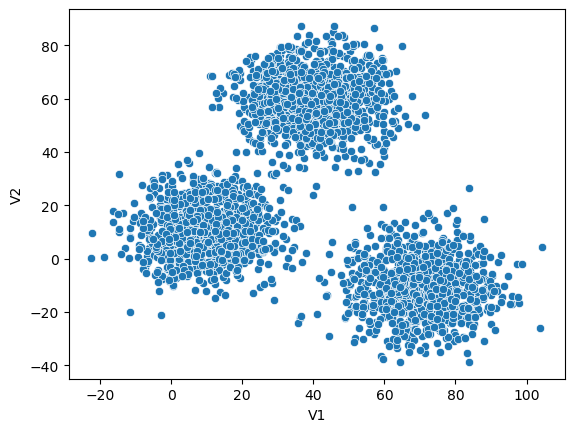

In [5]:
sbn.scatterplot(data = xclara, x = 'V1', y = 'V2')
plt.show()

Shapiro test of V1: ShapiroResult(statistic=0.9765937859538415, pvalue=8.218043011881079e-22)
Shapiro test of V2: ShapiroResult(statistic=0.9198960042737507, pvalue=2.94473635791596e-37)



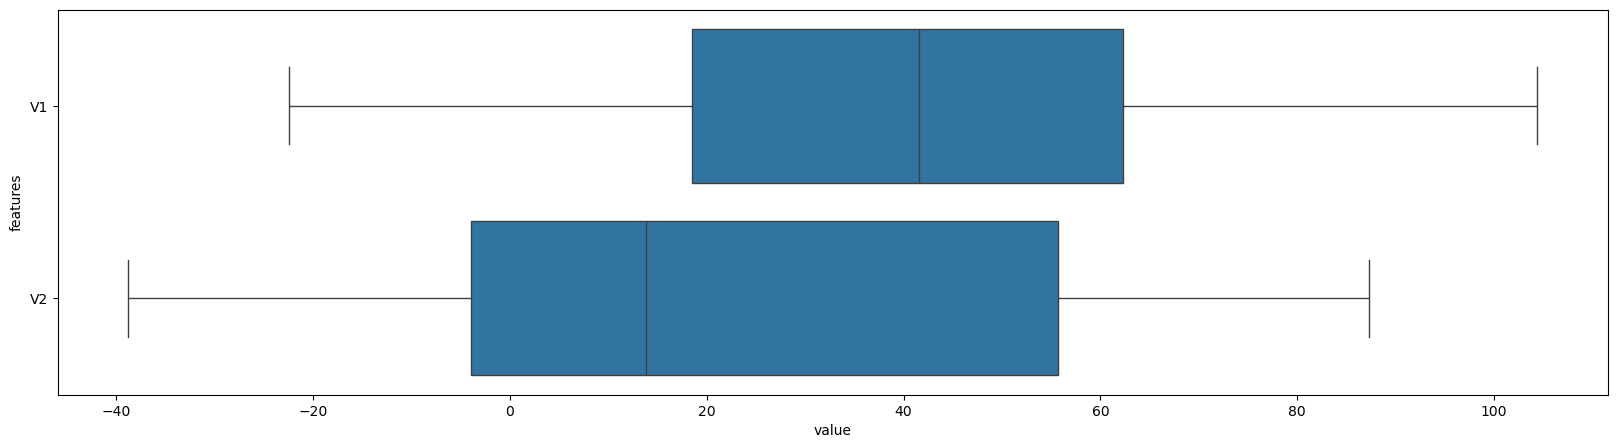


These features are not normally distributed, but have no outliers => Can use MinMaxScaler


In [6]:
from scipy.stats import shapiro
print(f'Shapiro test of V1: {shapiro(xclara['V1'])}')
print(f'Shapiro test of V2: {shapiro(xclara['V2'])}')

print()
plt.figure(figsize=(20, 5))
sbn.boxplot(xclara.melt(var_name = 'features', value_name = 'value'), x = 'value', y = 'features')
plt.show()

print('\nThese features are not normally distributed, but have no outliers => Can use MinMaxScaler')

## <span style = 'color : yellow'> Build HDBSCAN model to cluster data

In [13]:
import hdbscan
from sklearn.preprocessing import MinMaxScaler
from imblearn.pipeline import Pipeline

hdbscan_pipe = Pipeline([
    ('Scaler', MinMaxScaler()),
    ('HDBSCAN', hdbscan.HDBSCAN(min_cluster_size=20, min_samples=3))
])

hdbscan_pipe.fit(xclara)

labels = hdbscan_pipe.fit_predict(xclara)

xclara_clustered = xclara.copy()
xclara_clustered['Group'] = labels

print(f'All labels:\n {xclara_clustered['Group'].value_counts()}')

print()
print(xclara_clustered)

All labels:
 Group
 2    1139
 0     947
 1     879
-1      35
Name: count, dtype: int64

             V1         V2  Group
0      2.072345  -3.241693      1
1     17.936710  15.784810      1
2      1.083576   7.319176      1
3     11.120670  14.406780      1
4     23.711550   2.557729      1
...         ...        ...    ...
2995  85.652800  -6.461061      0
2996  82.770880  -2.373299      0
2997  64.465320 -10.501360      0
2998  90.722820 -12.255840      0
2999  64.879760 -24.877310      0

[3000 rows x 3 columns]


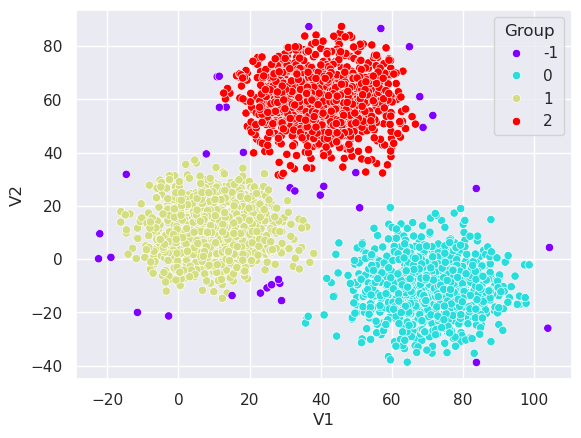

In [14]:
sbn.scatterplot(data = xclara_clustered, x = 'V1', y = 'V2', hue = 'Group', palette = 'rainbow')
plt.show()

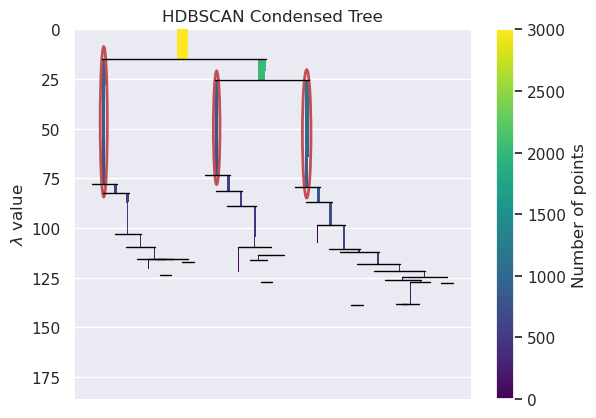

In [15]:
# Visualize the condensed tree
hdbscan_pipe.named_steps['HDBSCAN'].condensed_tree_.plot(select_clusters=True, cmap='viridis')
plt.title("HDBSCAN Condensed Tree")
plt.show()

## <span style = 'color : yellow'> Report clustering results

In [11]:
data_group = xclara_clustered[xclara_clustered['Group'] != -1]

for group in data_group['Group'].unique():
    print(f'\n=============== Cluster group {group} =========================\n')
    data = data_group[data_group['Group'] == group]
    
    print(f'n_observations: {data.shape[0]}\n')
    
    for col_name in data.columns[:-1]:
        print(f'{col_name}: {np.min(data[col_name])} ~ {np.median(data[col_name])} ~ {np.max(data[col_name])}')
        print()


=============== Cluster group 1 =========================

n_observations: 879

V1: -16.2653 ~ 9.339954 ~ 38.0434

V2: -14.739579999999998 ~ 10.42427 ~ 37.17632


=============== Cluster group 2 =========================

n_observations: 1139

V1: 12.71827 ~ 40.92554000000001 ~ 66.66133

V2: 31.39812 ~ 60.1302 ~ 87.3137


=============== Cluster group 0 =========================

n_observations: 947

V1: 35.74094 ~ 69.57141999999999 ~ 98.66974

V2: -38.68109000000001 ~ -9.938504 ~ 19.35797



Number of numeric fields: 2

All numeric fields: ['V1', 'V2']



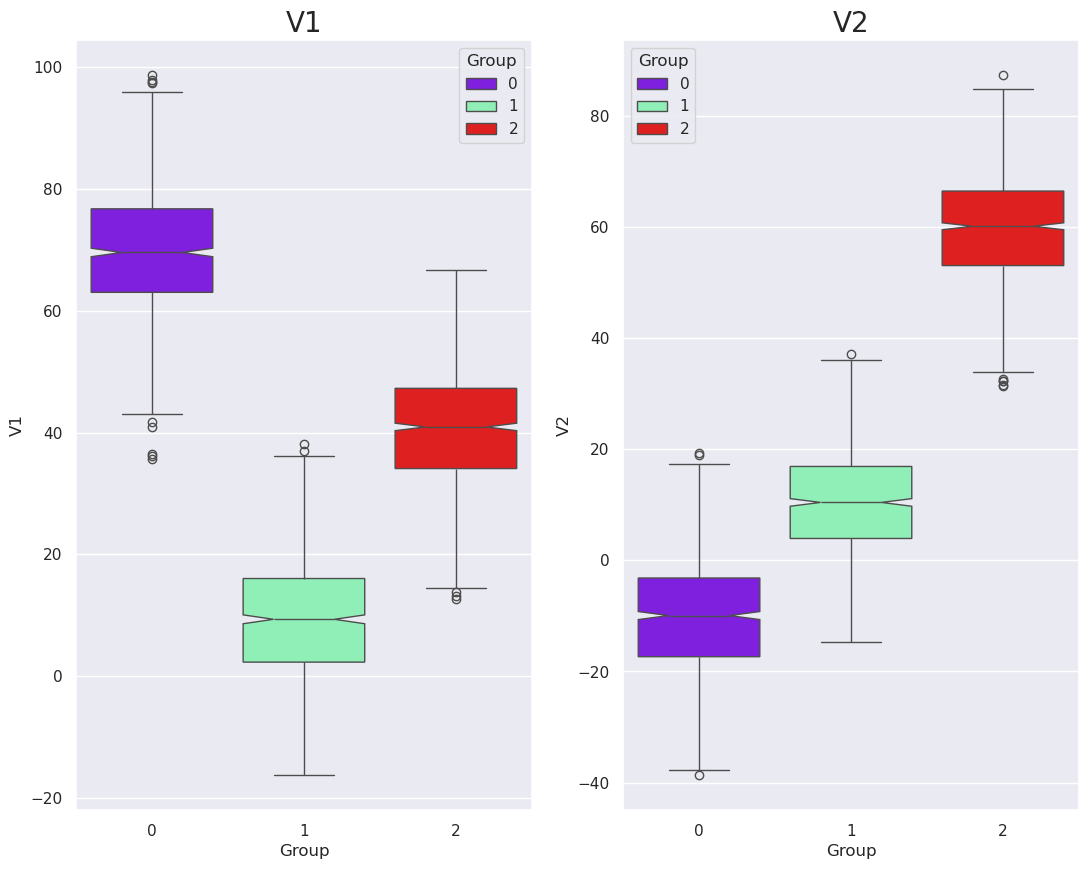

In [12]:
data_group = xclara_clustered[xclara_clustered['Group'] != -1]

numeric_cols = ['V1', 'V2']

##### Function building ##############

def boxplot_numeric(df, numeric_cols, figsize=(20, 10), groups = None):
    col = 3
    if (len(numeric_cols) % 3) == 0:
        row = len(numeric_cols) // 3
    else:
        row = (len(numeric_cols) // 3) + 1
    '''
    numeric_cols: list các tên cột biến định lượng
    row: số lượng dòng trong lưới đồ thị
    col: số lượng cột trong lưới đồ thị
    figsize: kích thước biểu đồ
    groups: tên cột chứa biến phân nhóm như 'Group' hoặc 'Class' hoặc 'Label'
    '''
    print(f'Number of numeric fields: {len(numeric_cols)}')
    print()
    print(f'All numeric fields: {numeric_cols}')
    print()
    plt.figure(figsize = figsize)
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.3)
    for i in range(1, len(numeric_cols)+1, 1):
      try:
        plt.subplot(row, col, i)
        sbn.boxplot(data = df, x = groups, y = numeric_cols[i-1], notch = True, hue = groups, palette = 'rainbow')
        plt.title(numeric_cols[i-1], size = 20)
      except:
        print('Error {}'.format(numeric_cols[i-1]))
        break
    plt.show()
## Draw
sbn.set_theme(style ='darkgrid')
boxplot_numeric(data_group, numeric_cols, groups = data_group.iloc[:,-1])